# Introduction

#_Brief Introduction to the project and its goals._#

# Setting up the Environment

### Importing Libraries

In [0]:
from dateutil import relativedelta

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Notebook Display Settings


In [0]:
# Change the maximum number of rows displayed when viewing the pandas dataframe
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

import os
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

### Default Figure Settings

In [0]:
# Set plot properties
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titleweight']='bold'
mpl.rcParams['axes.labelweight']='normal'
mpl.rcParams['figure.figsize']=(8,6)

# Choose the font for the plots based on os (as some fonts are not available across different os)
if os.name=='nt':
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['font.sans-serif'] = "Arial"
elif os.name=='posix':  
    mpl.rcParams['font.family'] = "Mukti Narrow"

# Enables colour codes for seaborn plots
sns.set(color_codes=True)

### Parallel Processing Configuration

In [0]:
import multiprocessing as mp

# Get the number of cpu available for parallel processing
n_cpu=mp.cpu_count()

# Data Transformation & Exploration

## Read the Data

In [0]:
# Read the csv file 
data=pd.read_csv('Data/epl-training.csv')

# Dropping the trailing columns
data.dropna(axis=1, how='all',inplace=True)
data['Date']=pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.drop([column for column in data.columns if 'Unnamed' in column], axis = 1, inplace=True) 
print("Shape of the table (rows, columns): ", data.shape)

Shape of the table (rows, columns):  (4180, 22)


In [0]:
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,2008-08-16,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0
1,2008-08-16,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0
2,2008-08-16,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0
3,2008-08-16,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0
4,2008-08-16,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0


## Exploratory Data Analysis

### Function definitions

The function __get_pivot_column_vs_column_count__ returns a dataframe after pivoting a column against another column. The elements of dataframe represent counts of all the different combinations of __col1__ and __col2__ in the dataframe __df__.

In [0]:
def get_pivot_column_vs_column_count(df,col1,col2):
    return df.groupby([col1,col2]).size().reset_index().\
              rename(columns={0:'counts'}).\
              pivot(values='counts',index=col1,columns=col2)

The function __get_column_countplot__ plots a bar chart. The bar chart is representative of the column __col__ in the dataframe __df__. The function counts the occurances of each value taken by __col__ in combination with the different outcome of __FTR__ (i.e. H, D, A). 

In [0]:
def get_column_countplot(df,col,y='FTR',ax=None ):
    if ax is None:
        ax = plt.gca()
    df.groupby([col, y]).size().reset_index().\
       pivot(columns=y, index=col, values=0).\
       plot(kind='bar', stacked=True,ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('Counts')
    ax.set_title('Count Plot: %s'%(col))

### Number of teams

#### Number of unique teams in the table:

In [0]:
data['HomeTeam'].nunique()

Number of unique teams in the table:  36


#### Checking if all the team in the column `HomeTeam` are in `AwayTeam`

In [0]:
np.array_equal(sorted(data['HomeTeam'].unique()),sorted(data['AwayTeam'].unique()))

True

#### List of all teams in the data:

In [0]:
print(sorted(data['HomeTeam'].unique()))

['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', 'Blackpool', 'Bolton', 'Bournemouth', 'Brighton', 'Burnley', 'Cardiff', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Huddersfield', 'Hull', 'Leicester', 'Liverpool', 'Man City', 'Man United', 'Middlesbrough', 'Newcastle', 'Norwich', 'Portsmouth', 'QPR', 'Reading', 'Southampton', 'Stoke', 'Sunderland', 'Swansea', 'Tottenham', 'Watford', 'West Brom', 'West Ham', 'Wigan', 'Wolves']


### Analysing the `Referee` column

#### The number of unique referees in dataset:

In [0]:
data['Referee'].nunique()

36

> It can be seen that the number of referees here is the same as the number of teams

In [0]:
data['Referee'].nunique()==data['HomeTeam'].nunique()

True

### Analysing the Dates

The first and the last date (when arranged chronologically) observed in the table:

In [0]:
print("The earliest date in the table: ", data['Date'].min())
print("The latest date in the table: ", data['Date'].max())

The earliest date in the table:  2008-08-16 00:00:00
The latest date in the table:  2019-05-12 00:00:00


In [0]:
rd = relativedelta.relativedelta(data['Date'].max(),data['Date'].min())
print('%d years %d months %d days'%(rd.years,rd.months,rd.days))

10 years 8 months 26 days


In [0]:
sorted((data['Date'].dt.month).unique())

[1, 2, 3, 4, 5, 8, 9, 10, 11, 12]

It can be seen here that 6 and 7 are missing.

> This means that no matches happen in June and July.

Therefore, we can consider that: 

> Each Season starts from __August to May__ and so we can deduce that the data covers __11 Seasons__

### Number of Matches played by the teams

A count of the occurances of each combination of Home and Away team allocation.

In [0]:
get_pivot_column_vs_column_count(data,'HomeTeam','AwayTeam')

AwayTeam,Arsenal,Aston Villa,Birmingham,Blackburn,Blackpool,Bolton,Bournemouth,Brighton,Burnley,Cardiff,Chelsea,Crystal Palace,Everton,Fulham,Huddersfield,Hull,Leicester,Liverpool,Man City,Man United,Middlesbrough,Newcastle,Norwich,Portsmouth,QPR,Reading,Southampton,Stoke,Sunderland,Swansea,Tottenham,Watford,West Brom,West Ham,Wigan,Wolves
HomeTeam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Arsenal,NaN,8.0,2.0,4.0,1.0,4.0,4.0,2.0,5.0,2.0,11.0,6.0,11.0,7.0,2.0,5.0,5.0,11.0,11.0,11.0,2.0,9.0,4.0,2.0,3.0,1.0,7.0,10.0,9.0,7.0,11.0,4.0,9.0,10.0,5.0,4.0
Aston Villa,8.0,NaN,2.0,4.0,1.0,4.0,1.0,NaN,2.0,1.0,8.0,3.0,8.0,6.0,NaN,4.0,2.0,8.0,8.0,8.0,1.0,7.0,4.0,2.0,3.0,1.0,4.0,8.0,8.0,5.0,8.0,1.0,7.0,7.0,5.0,3.0
Birmingham,2.0,2.0,NaN,2.0,1.0,2.0,NaN,NaN,1.0,NaN,2.0,NaN,2.0,2.0,NaN,1.0,NaN,2.0,2.0,2.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,2.0,2.0,NaN,2.0,NaN,1.0,2.0,2.0,2.0
Blackburn,4.0,4.0,2.0,NaN,1.0,4.0,NaN,NaN,1.0,NaN,4.0,NaN,4.0,4.0,NaN,2.0,NaN,4.0,4.0,4.0,1.0,3.0,1.0,2.0,1.0,NaN,NaN,4.0,4.0,1.0,4.0,NaN,3.0,3.0,4.0,3.0
Blackpool,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0
Bolton,4.0,4.0,2.0,4.0,1.0,NaN,NaN,NaN,1.0,NaN,4.0,NaN,4.0,4.0,NaN,2.0,NaN,4.0,4.0,4.0,1.0,3.0,1.0,2.0,1.0,NaN,NaN,4.0,4.0,1.0,4.0,NaN,3.0,3.0,4.0,3.0
Bournemouth,4.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,3.0,1.0,4.0,4.0,4.0,1.0,2.0,1.0,4.0,4.0,4.0,4.0,1.0,3.0,1.0,NaN,NaN,NaN,4.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,NaN,1.0
Brighton,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,1.0,2.0,2.0,2.0,1.0,2.0,NaN,2.0,2.0,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,1.0,2.0,2.0,1.0,2.0,NaN,1.0
Burnley,5.0,2.0,1.0,1.0,NaN,1.0,3.0,2.0,NaN,1.0,5.0,4.0,5.0,2.0,2.0,3.0,4.0,5.0,5.0,5.0,1.0,3.0,NaN,1.0,1.0,NaN,4.0,4.0,3.0,3.0,5.0,3.0,3.0,5.0,1.0,2.0


Checking how many matches each team played. As every match a home team plays at home comes in conjunction with one it plays away, it is sufficient to count the number of home matches. 

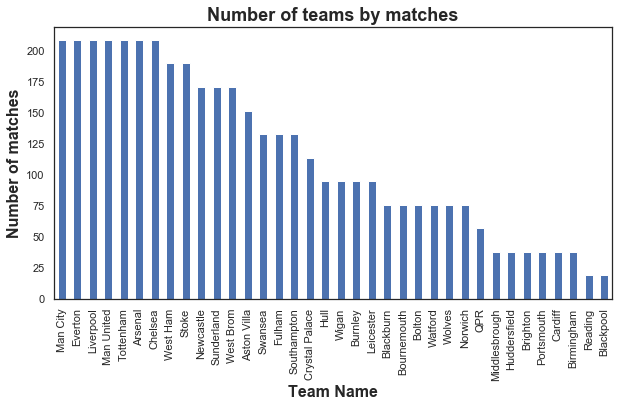

In [0]:
data.HomeTeam.value_counts().plot(kind='bar', figsize=(10,5))
plt.title('Number of teams by matches',fontsize=18, fontweight='bold')
plt.ylabel('Number of matches',fontsize=16, fontweight='bold')
plt.xlabel('Team Name',fontsize=16, fontweight='bold')
sns.set_style("white")
plt.show()

### HTR vs. FTR

A count plot to show the relationship between Half Time Result (`HTR`) and Full Time Result (`FTR`). This was done basically to check for how many of the matches the `HTR` and `FTR` result.

In [0]:
get_pivot_column_vs_column_count(data,'HTR','FTR')

FTR,A,D,H
HTR,,,
A,703,199,99
D,439,647,646
H,70,191,1186


###  Histogram (Count Plots) of all Features

The columns of the unprocessed dataset will later be used to extract information about the individual teams. To investigate the characteristics of each of the individual columns, we first utilize a histogram plot of each of the columns. Prior to obtaining this plot, all the categorical columns (Home Team, Away Team, Referee and Full Time Result) are turned into numerical values using the __Label_Encoder__ function.

Bar Chart for each of the numerical features in the imported dataset. The bar chart will show a count of the occurances of each unique value taken by each feautre. In addition to this, the bar chart will show what proportion of each unique value that resulted in Home win (__H__), Draw (__D__) or Away win (__A__).

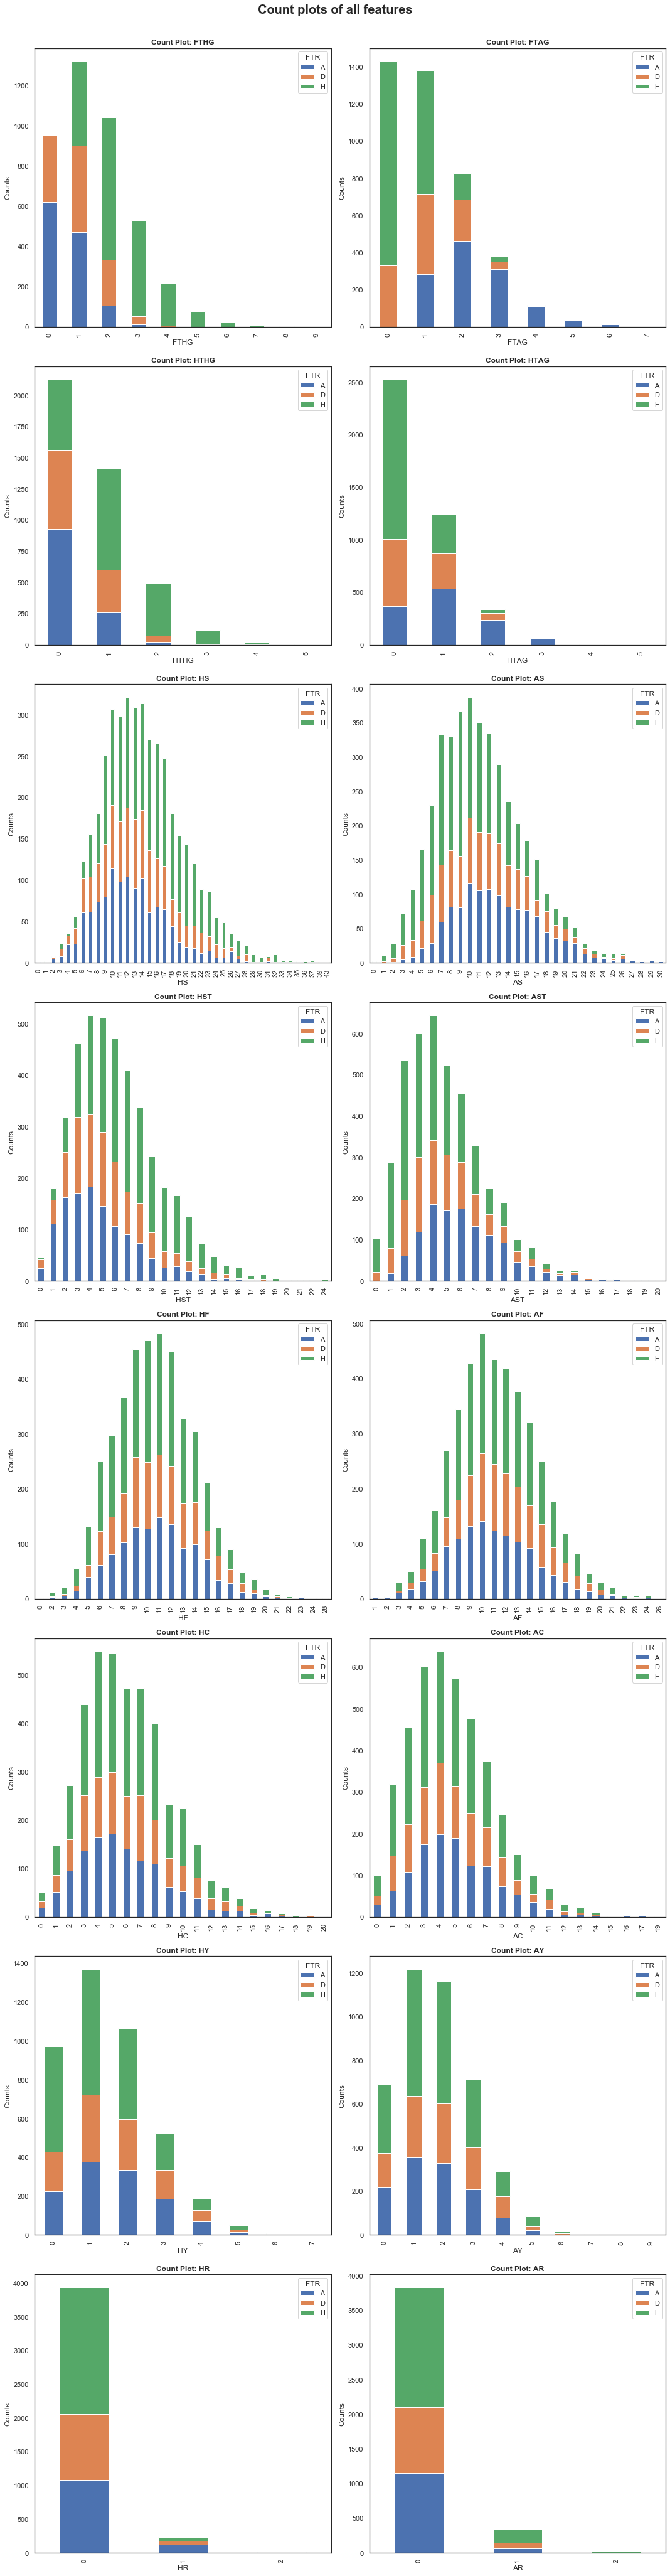

In [0]:
# Save the column names of numerical features as a list
num_col_list=[x for x in data.columns if x not in ['Date','HomeTeam','AwayTeam','Referee','FTR','HTR']]

# Reshaping array for easier formatting
num_col_list = np.reshape(num_col_list, (8, 2))

# Call the function get_column_countplot() to plot the count plot of the categorical columns as s ubplots in a figure
fig, axes = plt.subplots(8,2,figsize=(15,60))
for i in range(8):
    for j in range(2):
        get_column_countplot(data,num_col_list[i][j], ax=axes[i,j])
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle("Count plots of all features",fontweight='bold',fontsize=20)
sns.set_style("white")
plt.show()

### Checking if the dataset is balanced

A bar chart showing the number of home wins, draws and away wins.

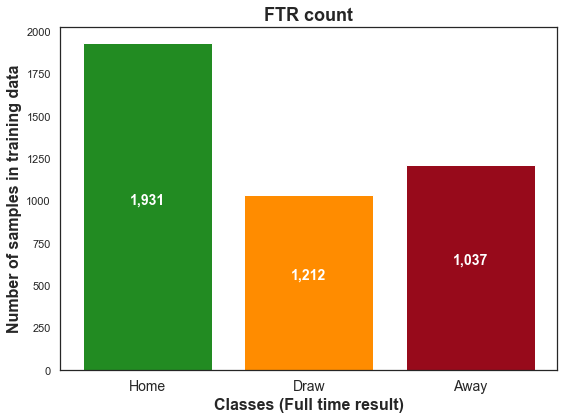

In [0]:
# Get the counts 
count_val=data['FTR'].value_counts()

# Visualise the count
X_ticks=['Home','Draw','Away']
bar_width=0.7
fig,ax=plt.subplots()
plt.bar(1,count_val[0],color='forestgreen')
plt.bar(2,count_val[2],color='darkorange')
plt.bar(3,count_val[1],color='#970a1b')
plt.text(1, count_val[0]/2, "{:,}".format(count_val[0]),color='w',
         ha='center', va= 'bottom',fontweight='bold',fontsize=14)
plt.text(2, count_val[2]/2, "{:,}".format(count_val[1]), color='w'
         ,ha='center', va= 'bottom',fontweight='bold',fontsize=14)
plt.text(3, count_val[1]/2, "{:,}".format(count_val[2]), color='w',
         ha='center', va= 'bottom', fontweight='bold', fontsize=14)
ax.set_title('FTR count', fontsize=18, fontweight='bold')
ax.set_xlabel('Classes (Full time result)', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of samples in training data', fontsize=16, fontweight='bold')
ax.set_xticks([1,2,3])
ax.set_xticklabels(X_ticks,fontsize=14)
fig.tight_layout()
sns.set_style("white")
plt.show()

#### Encoding the non-numerical columns

In [0]:
encoded_data = data.copy()

for column in ['HomeTeam','AwayTeam','Referee','FTR','HTR']:
    encoded_data[column] = LabelEncoder().fit_transform(encoded_data[column])

### Correlation Matrix of the Data

A visual plot of the correlation matrix between the all the raw columns of the provided dataset. This will help identify important columns as well as discard those that show no correlation. For this, the label encoded dataset will be utilized.

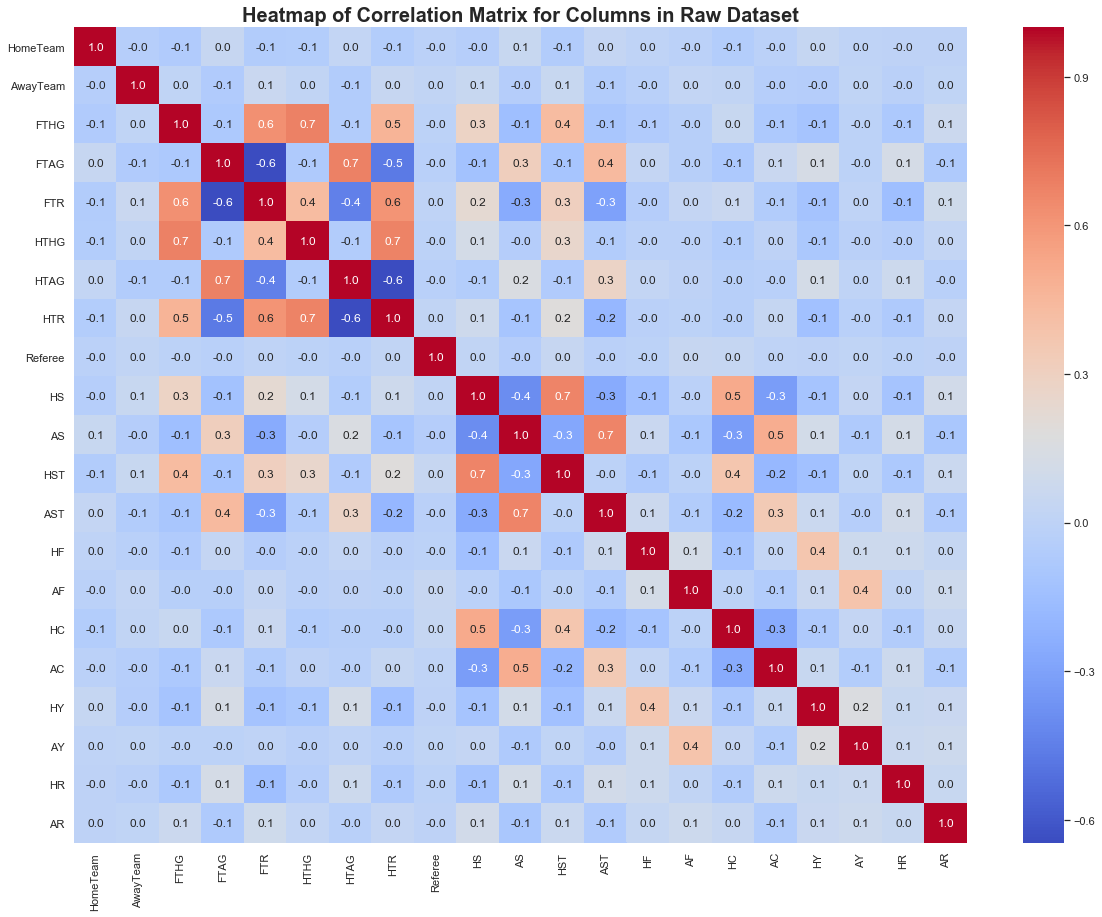

In [0]:
fig=plt.figure(figsize=(20,15))
ax = plt.subplot()
ax.set_title("Heatmap of Correlation Matrix for Columns in Raw Dataset",fontsize=20,fontweight='bold')
sns.heatmap(encoded_data.corr(), annot = True, fmt='.1f', cmap= 'coolwarm', ax=ax)
plt.show()

# Feature Extraction

### Average Goals, Points and Aggressiveness

Calculating average goals and scores for home teams and away teams. The scores are calculated by considering a win as 3 points, a draw as 1 point and a loss as 0 points. As the number of goals conceded by one team is the number of goals scored by the other team, the average number of goals conceded by the home team is equal to the number of goals scored by the away team (the same applies for goals conceded by the away team). These average values will be used to scale metrics later on in feature extraction to ensure that a value of 1 represents an average performance. This will ensure that the features are of similar scale. 

In [0]:
# Get total number of matches
num_matches = data.shape[0] 

# Sum home goals column, divide by total matches
average_home_goals = data.FTHG.sum()/num_matches

# Sum away goals column, divide by total matches
average_away_goals = data.FTAG.sum() /num_matches

# Average conceded goals = Average of goals for opposite team
avg_home_conceded = average_away_goals 
avg_away_conceded = avg_home_conceded

# Calculating points for each team
average_home_points = (3*count_val['H'] + count_val['D'])/num_matches
average_away_points = (3*count_val['A'] + count_val['D'])/num_matches

# Calculating other average  home and away
average_home_yellow = data.HY.sum()/num_matches
average_away_yellow = data.AY.sum()/num_matches
average_home_red = data.HR.sum()/num_matches
average_away_red = data.AR.sum()/num_matches
average_home_fouls = data.HF.sum()/num_matches
average_away_fouls = data.AF.sum()/num_matches

print('Average Home Goals:', average_home_goals)
print('Average Away Goals:', average_away_goals)
print('Average Home Points:',average_home_points)
print('Average Away Points:', average_away_points)
# print('Average Home Yellow Cards:', average_home_yellow)
# print('Average Away Yellow Cards:', average_away_yellow)
# print('Average Home Red Cards:',average_home_red)
# print('Average Away Red Cards:', average_away_red)
print('Average Home Fouls:',average_home_fouls)
print('Average Away Fouls:', average_away_fouls)

Average Home Goals: 1.555023923444976
Average Away Goals: 1.1708133971291865
Average Home Points: 1.6339712918660287
Average Away Points: 1.1179425837320573
Average Home Fouls: 10.682057416267943
Average Away Fouls: 11.204306220095694


### Team Statistics

Features in the raw data may be used to compute metrics that quantify different qualities of each team when they are playing at home and away. These quantities will be the same for all the home/away matches they play (i.e. a team will have the same Home Attacking Strength (HAS) for all games that it plays on home turf).

In [0]:
team_stats= pd.DataFrame(columns=('Team','HGS','AGS','HAS','AAS','HGC','AGC','HDS','ADS','HS','HST','AS','AST','HCON','ACON','HF','AF','HAGG','AAGG'))

In [0]:
# Group data by the teams
res_home = data.groupby('HomeTeam')
res_away = data.groupby('AwayTeam')

In [0]:
# Add the list of team names
team_stats.Team = pd.Series(data['HomeTeam'].unique())

In [0]:
# Home goal scored (HGS)
team_stats.HGS = res_home.FTHG.sum().values 
# Home goal conceded (HGC)
team_stats.HGC = res_home.FTAG.sum().values

In [0]:
# Away goal scored (AGS)
team_stats.AGS = res_away.FTAG.sum().values 
# Away goal conceded (AGC)
team_stats.AGC = res_away.FTHG.sum().values 

In [0]:
# Calculate number of games played
total_home_games_played = res_home.FTHG.count()
total_away_games_played = res_away.FTAG.count()

In [0]:
# Home Attacking Strength
team_stats.HAS = (np.divide(team_stats.HGS,total_home_games_played.values)) / average_home_goals
# Away Attacking Strength
team_stats.AAS = (np.divide(team_stats.AGS,total_away_games_played.values)) / average_away_goals

In [0]:
# Home Defensive Strength
team_stats.HDS = (np.divide(team_stats.HGC,total_home_games_played.values)) / avg_home_conceded
# Away Defensive Strength
team_stats.ADS = (np.divide(team_stats.AGC,total_away_games_played.values)) / avg_away_conceded

In [0]:
# Obtaining for each team: Average number of goals scored and conceded when at home and at away.
team_stats.GSA = (np.divide(team_stats.AGS,total_away_games_played.values))
team_stats.GSH = (np.divide(team_stats.HGS,total_home_games_played.values))

team_stats.GCA = (np.divide(team_stats.AGC,total_away_games_played.values))
team_stats.GCH = (np.divide(team_stats.HGC,total_home_games_played.values))

In [0]:
# Shots taken at home and away
team_stats.HS = res_home.HS.sum().values 
team_stats.AS = res_away.AS.sum().values

# Shots taken on target at home and away
team_stats.HST = res_home.HST.sum().values 
team_stats.AST = res_away.AST.sum().values

# Shot conversion rate (accuracy) at home and away
team_stats.HCON = (np.divide(team_stats.HST,team_stats.HS)) 
team_stats.ACON = (np.divide(team_stats.AST,team_stats.AS)) 

In [0]:
# Total number of fouls at home and away
team_stats.HF = res_home.HF.sum().values 
team_stats.AF = res_away.AF.sum().values

# A measure of aggressiveness for each team
team_stats.HAGG = (np.divide(team_stats.HF,total_home_games_played.values)) / average_home_fouls
team_stats.AAGG = (np.divide(team_stats.AF,total_away_games_played.values)) / average_away_fouls

In [0]:
team_stats.head()

,Team,HGS,AGS,HAS,AAS,HGC,AGC,HDS,ADS,HS,HST,AS,AST,HCON,ACON,HF,AF,HAGG,AAGG
0,0,441,356,1.356923,1.454843,174,292,0.711075,1.193298,3448,1641,2724,1276,0.475928,0.468429,2137,2134,0.957201,0.911304
1,5,179,156,0.757308,0.876584,198,264,1.112587,1.483449,1804,812,1478,693,0.450111,0.468877,1639,1825,1.009440,1.071604
2,12,38,37,0.643077,0.831631,35,70,0.786678,1.573355,379,186,321,189,0.490765,0.588785,390,417,0.960785,0.979417
3,15,98,77,0.829231,0.865345,90,162,1.011443,1.820597,949,501,689,385,0.527924,0.558781,957,950,1.178809,1.115642
4,20,30,25,1.015385,1.123825,37,41,1.663261,1.843073,253,134,193,101,0.529644,0.523316,216,187,1.064254,0.878422


Not all the features in the table above will be used in the final input features of the classifier. Some of these statistics are intermediate values which aided in the calculation of other statistics. For example the __HGS__ column was used to compute the __HAS__ column. 

### Calculation of Form

Form is a calculation of a team's recent performance. Additionally these statistics vary with different allocations. (i.e. a team may have different __FFPTSH__ for different matches played at home). The function __get_features_match__ takes a match info and number of matches as inputs. The function then finds the number of past matches where the two teams played each other. If __n__ or more such matches exist, then the function computes 3 quantities: __FFPTSH__: Average points of home team in the past n matches against the away team, __FFHG__: Average goals of away team against home team in past n matches and __FFAG__: Average goals of home team against away team in the past n matches. If no matches are found then, the average quantities for these statistics are used. 

In [0]:
def calc_points_and_goals(df,team_list):
  # This ifs control if the current home team was home team or away in the past matches between the team in order
  # to sum correctly home/away goals.
  points=[]
  for team in team_list:
    if df['HomeTeam'] == team:
        goals_home = df['FTHG']
        goals_away = df['FTAG']
        if df['FTR'] == 'H':
            pts = 3
        elif df['FTR'] == 'D':
            pts = 1
    if df['AwayTeam'] == team:
        goals_home = df['FTAG'] 
        goals_away = df['FTHG']
        if df['FTR'] == 'A':
            pts = 3
        elif df['FTR'] == 'D':
            pts = 1
    points.append(pts)
  if len(team_list)==1:   
    return pts[0], goals_home, goals_away
  elif len(team_list)==2:   
    return pts[0], pts[1], goals_home, goals_away

In [0]:
def get_form_match(match, n=5):
    team1 = match['HomeTeam']
    team2 = match['AwayTeam']
    # Constructing a table when all the matches between the two teams are shown.
    res = data[((data['HomeTeam']==team1) & (data['AwayTeam']==team2)) | ((data['AwayTeam']==team1) & (data['HomeTeam']==team2))]
    name = match.name
    idx = res.index.get_loc(name)
    if idx >= n: 
      #If there is at least n matches between the teams
      matches = res.iloc[idx-n:idx]
      matches[['pts_home','pts_away', 'goals_home', 'goals_away']]=matches.apply(calc_points_and_goals)
      pts_home_avg = matches['pts_home'].sum()/n
      pts_away_avg = matches['pts_away'].sum()/n
      goals_home_avg = matches['goals_home'].sum()/n
      goals_away_avg = matches['goals_away'].sum()/n
    elif idx == 0: 
      # If there is 0 matches between the teams
      pts_avg = average_home_points
      pts_avg = average_away_points
      goals_home_avg = average_home_goals
      goals_away_avg = average_away_goals
    else: 
      #Some games between the teams but not n
      matches = res.iloc[0:idx]
      m = len(matches)
      matches[['pts_home','pts_away', 'goals_home', 'goals_away']]=matches.apply(calc_points_and_goals)
      pts_home_avg = matches['pts_home'].sum()/m
      pts_away_avg = matches['pts_away'].sum()/m
      goals_home_avg = matches['goals_home'].sum()/m
      goals_away_avg = matches['goals_away'].sum()/m
    return pts_home_avg, pts_away_avg, goals_home_avg, goals_away_avg


Another measure of form is the winning streak of the team. The fucntion __get_features_streak_home__ takes match info and the number of matches to consider as the inputs. It computes three quantities: __PSH__ the point streak of the home team, __SSH__ the average goals over the past __n__ games for the home team and __CSH__ the average goals conceded over the past __n__ matches for the home team. A similar function called __get_features_streak_away__ does the same for the away team. 

In [0]:
def get_streak_team(match,team_type, n=15):
    team = match[team_type]
    team_stats = data[((data['HomeTeam']==team) | (data['AwayTeam']==team))]
    name = match.name
    idx = team_stats.index.get_loc(name)
    if idx == 0:
        pts_avg = average_home_points
        goals_scored_avg = average_home_goals
        goals_conceded_avg = average_away_goals
    else:
        if idx-n < 0:
            newidx = 0
        else:
            newidx = idx - n
        matches_team = team_stats.iloc[newidx:idx]
        m = len(matches_team)
        matches_team[['pts_home', 'goals_home', 'goals_away']]=matches_team.apply(calc_points_and_goals)
        pts_home_avg = matches_team['pts_home'].sum()/n
        goals_home_avg = matches_team['goals_home'].sum()/n
        goals_away_avg = matches_team['goals_away'].sum()/n
        pts_avg = pts/m
        goals_scored_avg = goals_scored/m
        goals_conceded_avg = goals_conceded/m
    return pts_avg, goals_scored_avg, goals_conceded_avg

# Data Pre-Processing

### Defining Input Features and Output Labels

The input features are the features that will eventually be used to train the classifier. Additionally the labels are the observed outcomes. The labels will be used to find the error in the classifier and thereby train the classifier. The function __match_with_team_stats__ add rows from the table __team_stats__ onto the table __X__ according to the value taken by __left_on__. This will be used to add team statistics of the home and away team as features. The __build_X__ function takes inputs of two tables __X__ and __team_stats__. It returns a complete table representing the full feature matrix that will be used to train and test models.

In [0]:
def match_with_team_stats(X,team_stats,col_to_add,left_on,right_on='Team'):
    X=pd.merge(X,team_stats[[right_on,col_to_add]],how='left',left_on=left_on,right_on=right_on,sort=False).\
                                                                                    drop(right_on, axis = 1) 
    return X

In [0]:
def build_X(X,team_stats):
    # Add Home Attacking Strength(HAS), Home Defensive Strength(HDS), Away Attacking Strength(AAS), 
    # Away Defensive Strength(ADS)
    X = match_with_team_stats(X,team_stats,'HAS','HomeTeam')
    X = match_with_team_stats(X,team_stats,'HDS','HomeTeam')
    X = match_with_team_stats(X,team_stats,'HCON','HomeTeam')
    X = match_with_team_stats(X,team_stats,'HAGG','HomeTeam')
    
    X = match_with_team_stats(X,team_stats,'AAS','AwayTeam')
    X = match_with_team_stats(X,team_stats,'ADS','AwayTeam')
    X = match_with_team_stats(X,team_stats,'ACON','AwayTeam')
    X = match_with_team_stats(X,team_stats,'AAGG','AwayTeam')
    
    # Add Home Shots on Target(HST), Away Shots on Target(AST), Home Corners(HC), Away Corners(AC) ??
    X[['FFPTSH','FFPTSA','FFHG','FFAG']] = X.apply(get_form_match, axis=1, result_type='expand')
    X[['PSH','SSH','CSH']] = X.apply(get_streak_team, axis=1, result_type='expand')
    X[['PSA','SSA','CSA']] = X.apply(get_streak_team, axis=1, result_type='expand')
    
    return X

In [0]:
X = data[['HomeTeam', 'AwayTeam']]
X = build_X(X,team_stats)

X.tail()

,HomeTeam,AwayTeam,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
4175,17,35,1.101538,0.919493,0.442366,1.014983,0.472007,1.505926,0.384393,1.129735,0.0,2.000000,0.400000,0.0,2.466667,0.800000,0.0,1.600000,1.066667
4176,19,9,0.693846,1.640785,0.310044,0.891805,1.356763,1.144258,0.455481,0.971516,0.0,3.000000,1.000000,0.0,1.400000,1.333333,0.0,0.866667,1.866667
4177,26,14,0.752137,1.073877,0.426641,1.024837,0.842869,1.505926,0.474432,1.036960,0.0,1.333333,0.666667,0.0,1.400000,1.666667,0.0,0.533333,2.533333
4178,30,12,0.724308,1.303637,0.396022,1.162796,0.831631,1.573355,0.588785,0.979417,0.0,3.400000,1.000000,0.0,1.266667,1.000000,0.0,1.266667,0.866667
4179,31,33,0.913846,1.159787,0.408699,0.980986,0.977728,1.652023,0.345367,0.829099,0.0,1.800000,1.000000,0.0,1.266667,1.533333,0.0,1.200000,1.466667


In [0]:
y = data[['FTR']]

y.head()

,FTR
0,2
1,2
2,0
3,2
4,2


### Label Encoding Categorical Columns

In [0]:
for column in ['HomeTeam','AwayTeam']:
    X[column] = LabelEncoder().fit_transform(X[column])
y = LabelEncoder().fit_transform(y)

### Exploratory Data Analysis on Engineered Features

A histogram plot of the number of occurances of the different values of each features.

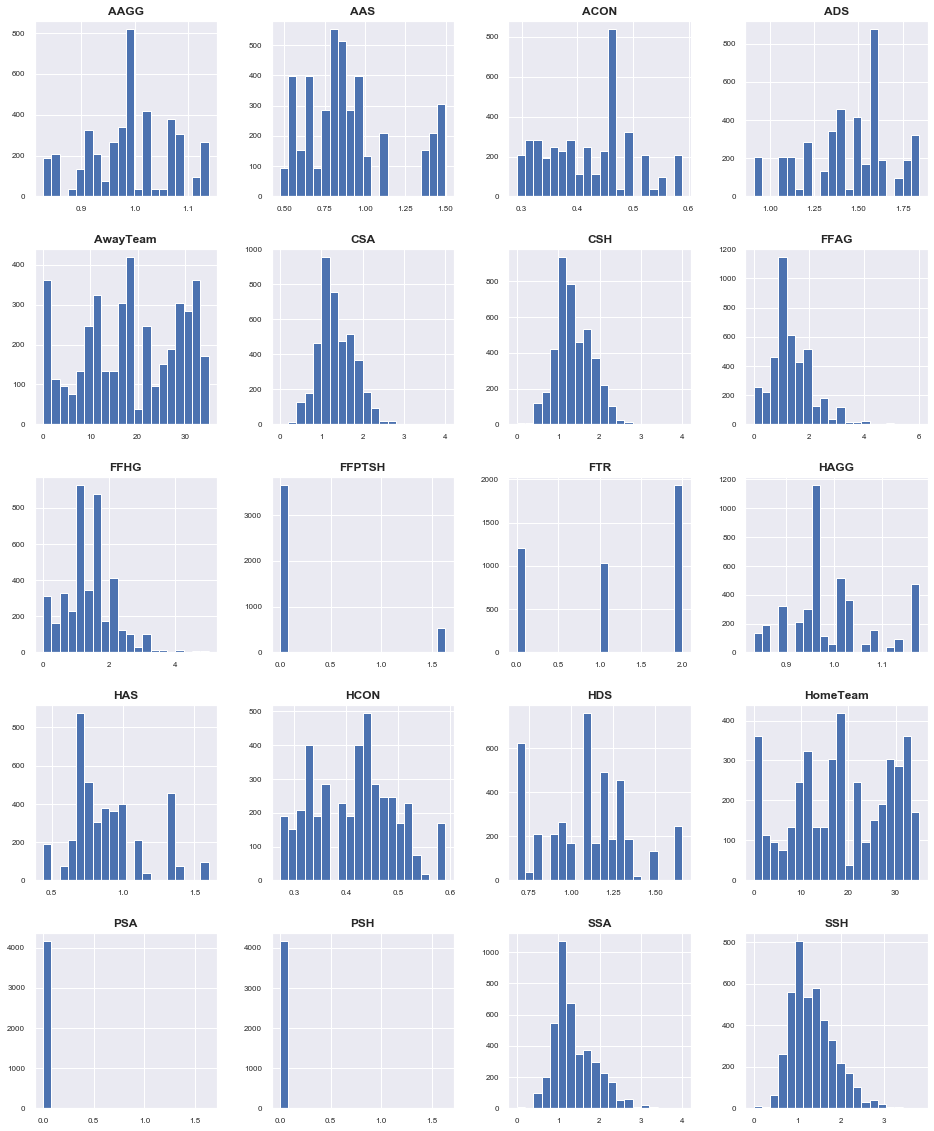

In [0]:
data_for_cor = X
data_for_cor['FTR'] = y

data_for_cor.hist(figsize=(16, 20), bins=20, xlabelsize=8, ylabelsize=8)
sns.set_style("white")

#### Correlation plot for Engineered Features

Similar to the correlation matrix plot for the raw column data, this plot visualizes the correlation between the engineered featuers, the competing teams and the full time result. This is represented on a heatmap.

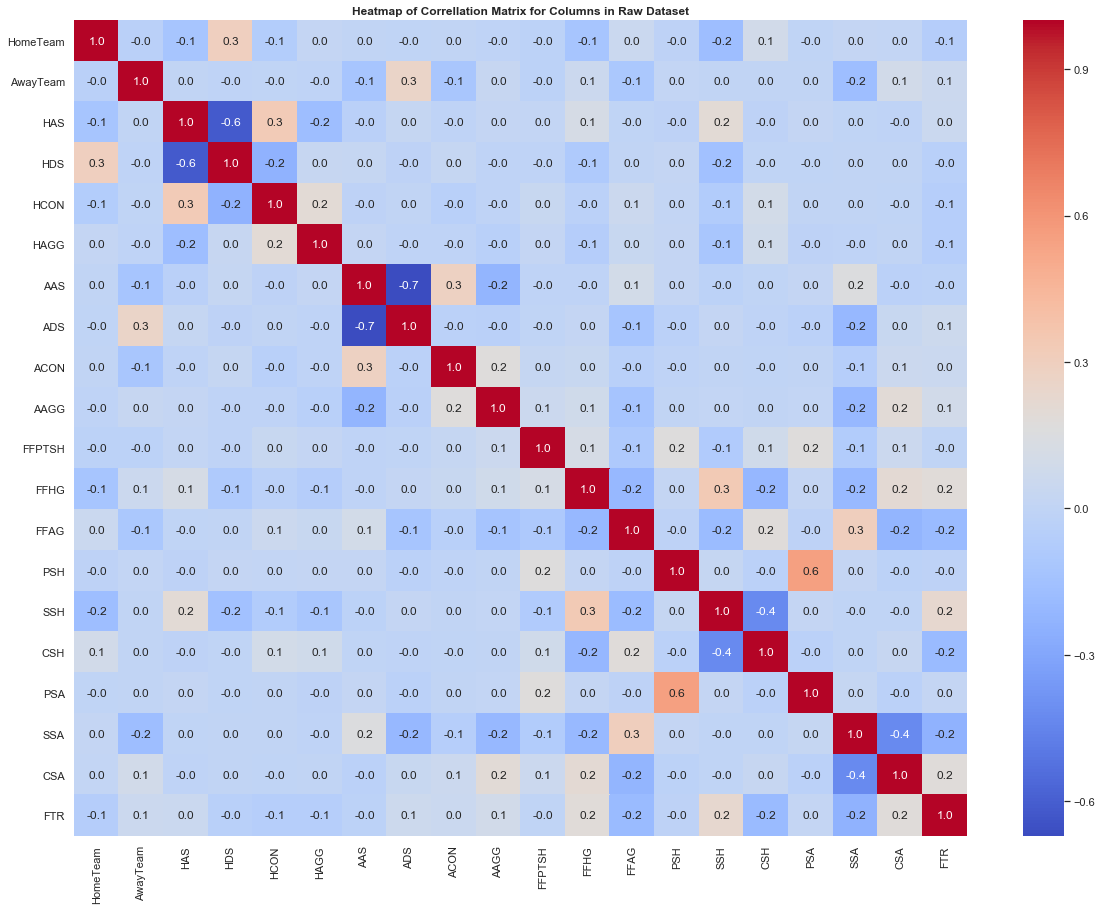

In [0]:
plt.figure(figsize=(20,15))
ax = plt.subplot(111)
ax.set_title("Heatmap of Correllation Matrix for Columns in Raw Dataset")
sns.heatmap(data_for_cor.corr(), annot = True, fmt='.1f', cmap= 'coolwarm', ax=ax)

### Scaling the features

In [0]:
X = X.apply(MinMaxScaler().fit_transform)

NameError: name 'X' is not defined

### Splitting into training and testing datasets

Splitting the full list of input features into training and testing datasets. The output labels are also split accordingly. The decided splitting ratio is 1:4 (test:train).

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Model Training

#### Functions to train the classifiers

In [0]:
def get_scores(model,X,y):
    '''
    Parameters:
        model
        X
        y
    
    Returns:
    '''
    scores = cross_validate(model_LR, X, y, scoring=('accuracy','f1_macro','precision_macro','recall_macro','roc_auc_ovr'),
                            cv=10, return_train_score=True,n_jobs=n_cpu)
    print('Accuracy: %f'%(scores['test_accuracy'].mean()))
    print('Precision: %f'%(scores['test_precision_macro'].mean()))
    print('Recall: %f'%(scores['test_recall_macro'].mean()))
    print('f1 Score: %f'%(scores['test_f1_macro'].mean()))
    print('ROC-AUC: %f'%(scores['test_roc_auc_ovr'].mean()))
    return scores

In [0]:
def get_best_params_RandomizedCV(model,X,y,param_grid,refit='accuracy'):
    '''
    This function executes the RandomizedSearchCV() to tune the 
    hyperparameters, prints the best scores and returns the list of 
    best performing hyperparameters.
    
    Parameters:
        model
        X
        y
        param_grid
        refit='accuracy'
    
    Returns:
        grid_results.best_params_ (dictionary):
    '''
    scoring=('accuracy','f1_macro','roc_auc_ovr')
    other_scores=[score for score in list(scoring) if score!=refit] 
    grid_results = RandomizedSearchCV(model, param_grid, 
                                       cv=10,n_jobs=n_cpu,
                                       scoring=scoring,
                                       refit=refit)
    grid_results.fit(X, y)
    print('Best parameters: \n',grid_results.best_params_)
    cv_results=grid_results.cv_results_
    best_index_results = np.nonzero(cv_results['rank_test_%s'%(refit)] == 1)[0][0]
    print('Best mean %s Score: '%(refit),grid_results.best_score_)
    print('Best mean %s Score: '%(other_scores[0]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    print('Best mean %s Score: '%(other_scores[1]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    return grid_results.best_params_

In [0]:
def get_best_params_GridCV(model,X,y,param_grid,refit='accuracy'):
    '''
    This function executes the GridSearchCV() to tune the 
    hyperparameters, prints the best scores and returns the list of 
    best performing hyperparameters.
    
    Parameters:
    model
    X
    y
    param_grid
    refit='accuracy'
    
    Returns:
    grid_results.best_params_ (dictionary):
    '''
    scoring=('accuracy','f1_macro','roc_auc_ovr')
    other_scores=[score for score in list(scoring) if score!=refit] 
    grid_results = GridSearchCV(model, param_grid, 
                                       cv=10,n_jobs=n_cpu,
                                       scoring=scoring,
                                       refit=refit)
    grid_results.fit(X, y)
    print('Best parameters: \n',grid_results.best_params_)
    cv_results=grid_results.cv_results_
    best_index_results = np.nonzero(cv_results['rank_test_%s'%(refit)] == 1)[0][0]
    print('Best mean %s Score: '%(refit),grid_results.best_score_)
    print('Best mean %s Score: '%(other_scores[0]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    print('Best mean %s Score: '%(other_scores[1]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    return grid_results.best_params_

### Logistic Regression

In [0]:
model_LR = LogisticRegression(n_jobs=n_cpu)
scores_LR=get_scores(model_LR,X_train,y_train)

np.random.seed(int(time.time()))

param_grid_LR={'penalty' : ['l1', 'l2', 'elasticnet'],
               'C' : [1, 10, 100, 1000],
               'solver' : ['newton-cg', 'sag','saga', 'lbfgs'],
              'fit_intercept' : [True, False]}

best_params_LR=get_best_params_GridCV(model_LR, X_train, y_train, param_grid_LR, refit='accuracy')

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
f1 Score: 1.000000
ROC-AUC: 1.000000
Best parameters: 
 {'C': 1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}
Best mean accuracy Score:  1.0
Best mean f1_macro Score:  1.0
Best mean roc_auc_ovr Score:  1.0


### Multi-Layer Perceptron Neural Network

In [0]:
model_mlp = MLPClassifier(solver='sgd',activation='identity',learning_rate='adaptive', 
                          hidden_layer_sizes=(8, 2), random_state=76)
scores_mlp=get_scores(model_nlp,X_train,y_train)


param_grid_LR={'penalty' : ['l1', 'l2', 'elasticnet'],
               'solver' : ['newton-cg', 'sag','saga', 'lbfgs'],
              'fit_intercept' : [True, False]}
best_params_LR=get_best_params_GridCV(model_LR,X_train,y_train,param_grid_LR,refit='accuracy')

get_scores(model_tuned, X, y)

NameError: name 'MLPClassifier' is not defined